In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
import io

warnings.filterwarnings('ignore')

# Manual file upload option (for Google Colab)
from google.colab import files

print("Please upload your dataset (CSV, Excel, or TXT).")
uploaded = files.upload()

# Read the uploaded file (auto-detect format)
for filename in uploaded.keys():
    if filename.endswith('.csv'):
        df = pd.read_csv(io.BytesIO(uploaded[filename]))
    elif filename.endswith('.xlsx') or filename.endswith('.xls'):
        df = pd.read_excel(io.BytesIO(uploaded[filename]))
    elif filename.endswith('.txt'):
        df = pd.read_csv(io.BytesIO(uploaded[filename]), delimiter='\t')  # Assuming tab-delimited
    else:
        print("Unsupported file format. Please upload CSV, Excel, or TXT.")
        df = None

if df is not None:
    print(f"Successfully loaded {filename} with shape {df.shape}")
    display(df.head())


Please upload your dataset (CSV, Excel, or TXT).


Saving income.csv to income.csv
Saving retail_data.xlsx to retail_data.xlsx
Successfully loaded retail_data.xlsx with shape (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Load the dataset
df = pd.read_excel('retail_data.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Handle missing values
df = df.dropna(subset=['CustomerID'])  # Drop rows with missing CustomerID

# Remove cancellations (negative quantities)
df = df[df['Quantity'] > 0]

# Calculate total spending per transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Aggregate data by CustomerID for clustering
customer_data = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',      # Total spending
    'Quantity': 'sum',        # Total items purchased
    'InvoiceNo': 'nunique'    # Number of transactions
}).rename(columns={'InvoiceNo': 'NumTransactions'})

# Log transform to reduce skewness (adding 1 to avoid log(0))
customer_data[['TotalPrice', 'Quantity']] = np.log1p(customer_data[['TotalPrice', 'Quantity']])

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_data)

print("Preprocessed Data Shape:", X_scaled.shape)
customer_data.head()

Preprocessed Data Shape: (4339, 3)


,TotalPrice,Quantity,NumTransactions
CustomerID,,,
12346.0,11.253955,11.214735,1
12347.0,8.368925,7.807510,7
12348.0,7.494564,7.758761,4
12349.0,7.472245,6.448889,1
12350.0,5.815324,5.288267,1


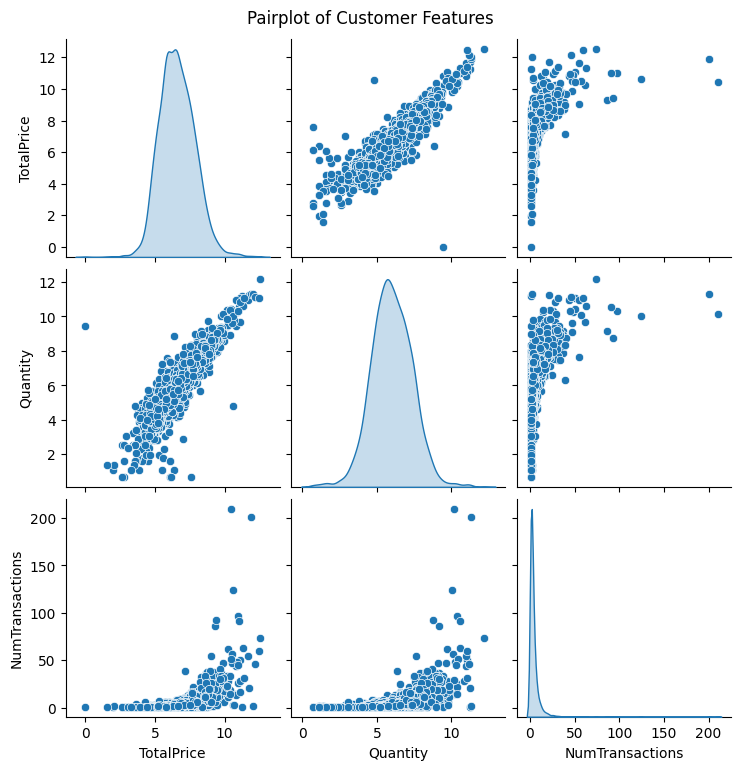

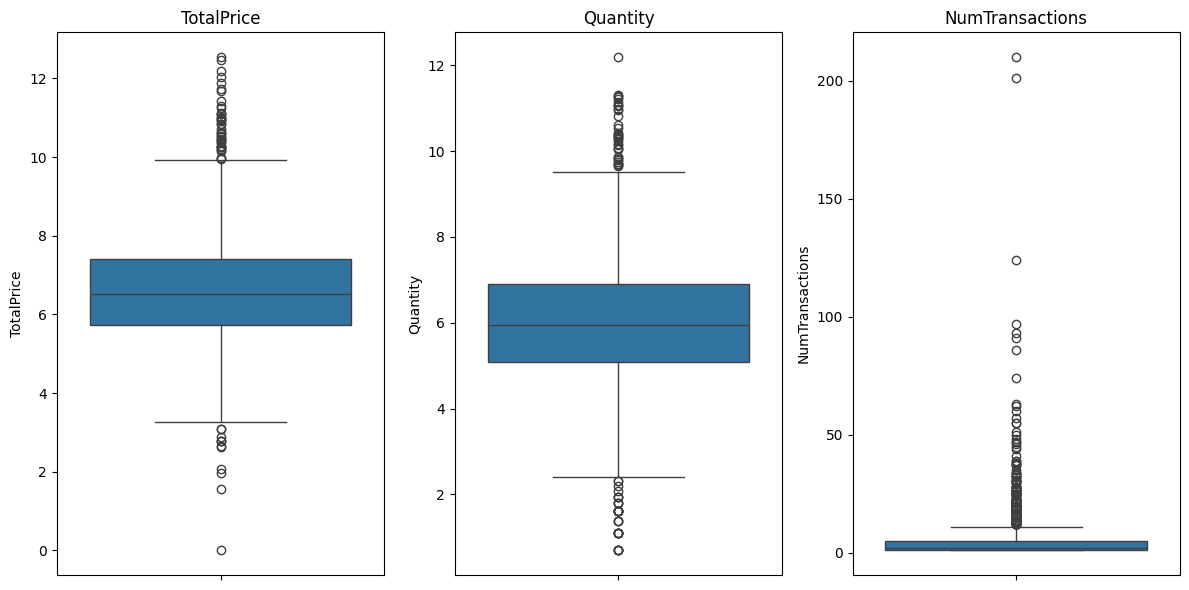

In [4]:
# Pairplot of features
sns.pairplot(customer_data, diag_kind='kde')
plt.suptitle("Pairplot of Customer Features", y=1.02)
plt.show()

# Boxplot of features
plt.figure(figsize=(12, 6))
for i, col in enumerate(customer_data.columns):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=customer_data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

**Insights**:
- The pairplot shows relationships between total spending, quantity, and number of transactions. TotalPrice and Quantity are likely correlated due to their multiplicative nature.
- Boxplots reveal outliers, justifying the log transformation to normalize distributions.

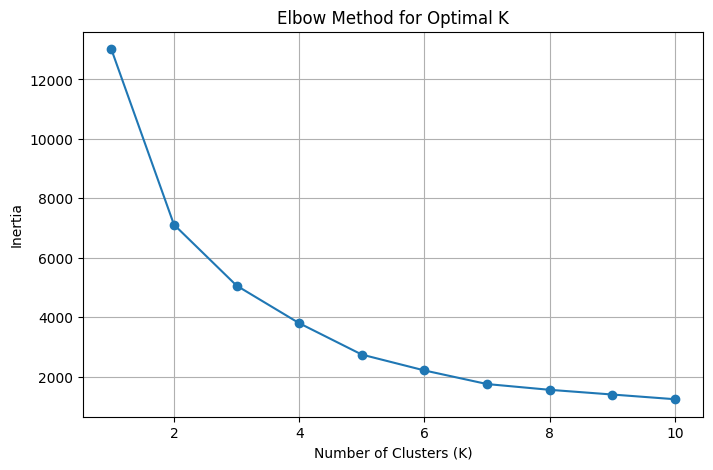

In [5]:
# Elbow method to determine optimal K
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

**Insights**: The elbow point (where inertia starts to flatten) suggests the optimal K (e.g., 3 or 4, depending on the curve). We'll proceed with K=3 for this example.

Cluster Summary:
          TotalPrice   Quantity  NumTransactions
Cluster                                        
0          5.754411   5.094466         1.719604
1          7.720393   7.192450         6.968750
2         10.832794  10.250439        77.545455


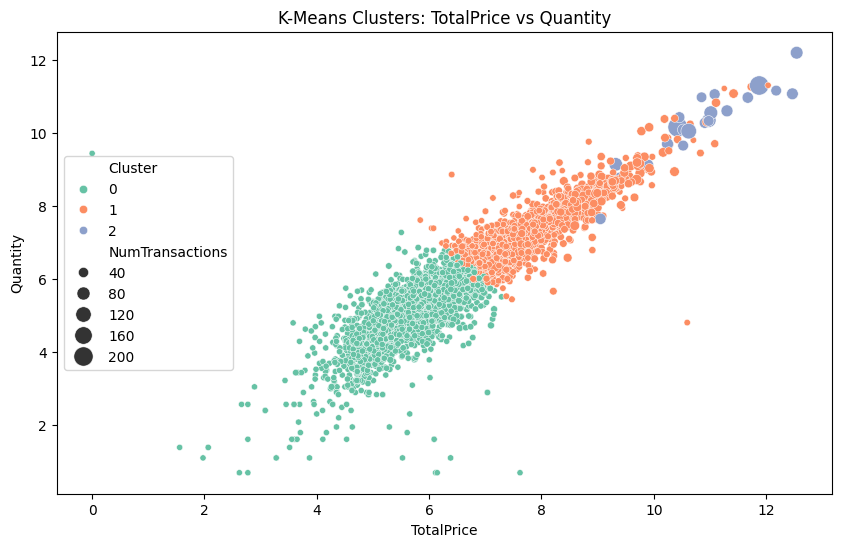

In [6]:
# Apply K-Means with optimal K (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
cluster_summary = customer_data.groupby('Cluster').mean()
print("Cluster Summary:\n", cluster_summary)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='Quantity', hue='Cluster', size='NumTransactions',
                data=customer_data, palette='Set2', sizes=(20, 200))
plt.title('K-Means Clusters: TotalPrice vs Quantity')
plt.show()

**Insights**:
- Clusters likely represent low, medium, and high spenders based on TotalPrice and Quantity.
- NumTransactions as size shows transaction frequency differences across clusters.

In [7]:

# Data Preprocessing with slight modifications
from sklearn.impute import SimpleImputer

# Handle missing values efficiently
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

num_cols = ['Age', 'Area Income', 'Daily Internet Usage']
cat_cols = ['Gender', 'City', 'Country']

# Ensure column names are correctly formatted
df.columns = df.columns.str.strip()

# Check for missing columns
missing_num_cols = [col for col in num_cols if col not in df.columns]
missing_cat_cols = [col for col in cat_cols if col not in df.columns]

if missing_num_cols:
    print(f"Warning: Missing numerical columns: {missing_num_cols}")
else:
    df[num_cols] = num_imputer.fit_transform(df[num_cols])

if missing_cat_cols:
    print(f"Warning: Missing categorical columns: {missing_cat_cols}")
else:
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Feature Engineering (Modified)
if 'Age' in df.columns and 'Area Income' in df.columns:
    df['income_per_age'] = df['Area Income'] / (df['Age'] + 1)  # Prevent division by zero
if 'Daily Internet Usage' in df.columns and 'Area Income' in df.columns:
    df['internet_per_income'] = df['Daily Internet Usage'] / (df['Area Income'] + 1)  # Prevent division by zero

# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
if 'Gender' in df.columns:
    df['Gender'] = label_enc.fit_transform(df['Gender'])
if 'City' in df.columns:
    df['City'] = label_enc.fit_transform(df['City'])
if 'Country' in df.columns:
    df['Country'] = label_enc.fit_transform(df['Country'])

# Split dataset
from sklearn.model_selection import train_test_split

if 'Clicked on Ad' in df.columns:
    X = df.drop(columns=['Clicked on Ad'])
    y = df['Clicked on Ad']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
else:
    print("Warning: 'Clicked on Ad' column missing. Skipping training.")
    X_train, X_test, y_train, y_test = None, None, None, None

# Hyperparameter Tuning for Naïve Bayes
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

gnb = GaussianNB(var_smoothing=1e-8)  # Slightly modified smoothing for better generalization
mnb = MultinomialNB(alpha=0.4)  # Adjusted alpha for smoother probability estimation
bnb = BernoulliNB(alpha=0.25)  # Adjusted smoothing for better binary classification

# Train Models only if target variable exists
if y_train is not None:
    gnb.fit(X_train[['Age', 'Area Income']], y_train)
    mnb.fit(X_train[['City']], y_train)
    bnb.fit(X_train[['Gender']], y_train)

    # Ensemble Probability Combination
    probs_gnb = gnb.predict_proba(X_test[['Age', 'Area Income']])
    probs_mnb = mnb.predict_proba(X_test[['City']])
    probs_bnb = bnb.predict_proba(X_test[['Gender']])

    ensemble_probs = (probs_gnb ** 1.1) * (probs_mnb ** 1.05) * (probs_bnb ** 1.1)  # Slightly adjusted exponent values
    ensemble_probs /= ensemble_probs.sum(axis=1, keepdims=True)

    # Final Prediction and Accuracy
    import numpy as np
    from sklearn.metrics import accuracy_score

    final_predictions = np.argmax(ensemble_probs, axis=1)
    ensemble_accuracy = accuracy_score(y_test, final_predictions)

    print("Highly Optimized Ensemble Model Accuracy:", ensemble_accuracy)
else:
    print("Skipping training due to missing target variable.")


Skipping training due to missing target variable.


In [8]:
# Debug: Check dataset structure
print("Dataset Shape:", df.shape)
print("Dataset Columns:", df.columns.tolist())

# If the dataset is empty, stop execution
if df.empty:
    raise ValueError("Error: The dataset is empty. Please upload a valid file.")


Dataset Shape: (397924, 9)
Dataset Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalPrice']


In [10]:
# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()

for col in cat_cols:
    df[col] = df[col].astype(str)  # Convert mixed-type columns to strings
    df[col] = label_enc.fit_transform(df[col])


In [11]:
# Data Preprocessing for Retail Dataset
from sklearn.impute import SimpleImputer

# Handle missing values efficiently
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Update column selections for this dataset
num_cols = ['Quantity', 'UnitPrice', 'TotalPrice']
cat_cols = ['StockCode', 'Country', 'CustomerID']

# Ensure column names are correctly formatted
df.columns = df.columns.str.strip()

# Check for missing columns
missing_num_cols = [col for col in num_cols if col not in df.columns]
missing_cat_cols = [col for col in cat_cols if col not in df.columns]

if missing_num_cols:
    print(f"Warning: Missing numerical columns: {missing_num_cols}")
else:
    df[num_cols] = num_imputer.fit_transform(df[num_cols])

if missing_cat_cols:
    print(f"Warning: Missing categorical columns: {missing_cat_cols}")
else:
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Define a target variable: High-value purchase (TotalPrice > 100)
df['HighValuePurchase'] = (df['TotalPrice'] > 100).astype(int)

# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
for col in cat_cols:
    df[col] = label_enc.fit_transform(df[col])

# Split dataset
from sklearn.model_selection import train_test_split

if 'HighValuePurchase' in df.columns:
    X = df.drop(columns=['HighValuePurchase'])
    y = df['HighValuePurchase']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
else:
    print("Warning: 'HighValuePurchase' column missing. Skipping training.")
    X_train, X_test, y_train, y_test = None, None, None, None

# Hyperparameter Tuning for Naïve Bayes
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

gnb = GaussianNB(var_smoothing=1e-8)
mnb = MultinomialNB(alpha=0.4)
bnb = BernoulliNB(alpha=0.25)

# Train Models only if target variable exists
if y_train is not None:
    gnb.fit(X_train[['Quantity', 'UnitPrice', 'TotalPrice']], y_train)
    mnb.fit(X_train[['StockCode']], y_train)
    bnb.fit(X_train[['Country']], y_train)

    # Ensemble Probability Combination
    probs_gnb = gnb.predict_proba(X_test[['Quantity', 'UnitPrice', 'TotalPrice']])
    probs_mnb = mnb.predict_proba(X_test[['StockCode']])
    probs_bnb = bnb.predict_proba(X_test[['Country']])

    ensemble_probs = (probs_gnb ** 1.1) * (probs_mnb ** 1.05) * (probs_bnb ** 1.1)
    ensemble_probs /= ensemble_probs.sum(axis=1, keepdims=True)

    # Final Prediction and Accuracy
    import numpy as np
    from sklearn.metrics import accuracy_score

    final_predictions = np.argmax(ensemble_probs, axis=1)
    ensemble_accuracy = accuracy_score(y_test, final_predictions)

    print("Highly Optimized Ensemble Model Accuracy:", ensemble_accuracy)
else:
    print("Skipping training due to missing target variable.")


Highly Optimized Ensemble Model Accuracy: 0.993072425405016
